# 基于《 Deep Learning with Python 》一书的Keras学习

In [1]:
from __future__ import print_function, division
import jupyterthemes.jtplot as jtplot
jtplot.style()
import numpy as np
import pandas as pd
import matplotlib as mpl
import os, shutil, random, sys
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(suppress=True)

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing import sequence, image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.utils import to_categorical  # one_hot编码
from keras.layers import Dense, Input, Embedding, SimpleRNN, LSTM, Bidirectional, GRU  # RNN相关框架
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, GlobalMaxPooling1D  # CNN 相关层
from keras.layers import Flatten, Activation, Dropout  # 特殊功能层
from keras.optimizers import Adadelta, Adam, RMSprop
from keras import losses, metrics
from keras.datasets import imdb  # 内置数据集
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, TensorBoard

Using TensorFlow backend.


# 分类

## 电影评论分类：二分类问题

In [2]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000)  # 保留前10000个常用词语
# 反向解码
'''
word_index = imdb.get_word_index()
reverse_word_index = dict([(value,key) for (key,value) in word_index.items()])
decoded_review = "".join([reverse_word_index.get(i-3,"?") for i in train_data[0]])
'''

'\nword_index = imdb.get_word_index()\nreverse_word_index = dict([(value,key) for (key,value) in word_index.items()])\ndecoded_review = "".join([reverse_word_index.get(i-3,"?") for i in train_data[0]])\n'

In [3]:
# 数据向量化（非常重要）
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results


X_train = vectorize_sequences(train_data)
X_test = vectorize_sequences(test_data)
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

X_val = X_train[:10000]
partical_X_train = X_train[10000:]
y_val = y_train[:10000]
partical_y_train = y_train[10000:]

In [4]:
# 定义模型
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(10000, )))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# 编译模型
model.compile(optimizer=RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

cost = model.fit(partical_X_train,
                 partical_y_train,
                 epochs=6,
                 batch_size=512,
                 validation_data=(X_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/6
15000/15000 [==============================] - 3s 181us/step - loss: 0.5101 - binary_accuracy: 0.7817 - val_loss: 0.4305 - val_binary_accuracy: 0.8268
Epoch 2/6
15000/15000 [==============================] - 2s 157us/step - loss: 0.3071 - binary_accuracy: 0.9036 - val_loss: 0.3065 - val_binary_accuracy: 0.8887
Epoch 3/6
15000/15000 [==============================] - 2s 145us/step - loss: 0.2268 - binary_accuracy: 0.9271 - val_loss: 0.2805 - val_binary_accuracy: 0.8907
Epoch 4/6
15000/15000 [==============================] - 2s 145us/step - loss: 0.1803 - binary_accuracy: 0.9419 - val_loss: 0.2777 - val_binary_accuracy: 0.8908
Epoch 5/6
15000/15000 [==============================] - 2s 143us/step - loss: 0.1450 - binary_accuracy: 0.9539 - val_loss: 0.2820 - val_binary_accuracy: 0.8891
Epoch 6/6
15000/15000 [==============================] - 2s 143us/step - loss: 0.1230 - binary_accuracy: 0.9615 - val_loss: 0.3288 - val_binary_a

In [5]:
results = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

25000/25000 [==============================] - 3s 112us/step


In [6]:
y_pred

array([[0.10549685],
       [0.9998165 ],
       [0.7602266 ],
       ...,
       [0.05308497],
       [0.05476692],
       [0.35556418]], dtype=float32)

## 新闻分类：多分类问题

In [7]:
from keras.datasets import reuters

(train_data, train_labels), (test_data,
                             test_labels) = reuters.load_data(num_words=10000)

In [8]:
X_train = vectorize_sequences(train_data)
X_test = vectorize_sequences(test_data)
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)
X_val = X_train[:1000]
partical_X_train = X_train[1000:]
y_val = y_train[:1000]
partical_y_train = y_train[1000:]

In [9]:
# 搭建网络
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(10000, )))
model.add(Dense(64, activation='relu'))
model.add(Dense(46, activation='softmax'))
# 编译模型
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# 训练模型
cost = model.fit(partical_X_train,
                 partical_y_train,
                 epochs=9,
                 batch_size=512,
                 validation_data=(X_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 1s 148us/step - loss: 2.5538 - accuracy: 0.5438 - val_loss: 1.6907 - val_accuracy: 0.6540
Epoch 2/9
7982/7982 [==============================] - 1s 123us/step - loss: 1.3661 - accuracy: 0.7145 - val_loss: 1.2606 - val_accuracy: 0.7300
Epoch 3/9
7982/7982 [==============================] - 1s 119us/step - loss: 1.0104 - accuracy: 0.7853 - val_loss: 1.1046 - val_accuracy: 0.7530
Epoch 4/9
7982/7982 [==============================] - 1s 169us/step - loss: 0.7963 - accuracy: 0.8310 - val_loss: 1.0143 - val_accuracy: 0.7890
Epoch 5/9
7982/7982 [==============================] - 1s 180us/step - loss: 0.6363 - accuracy: 0.8676 - val_loss: 0.9674 - val_accuracy: 0.8050
Epoch 6/9
7982/7982 [==============================] - 1s 178us/step - loss: 0.5086 - accuracy: 0.9002 - val_loss: 0.9327 - val_accuracy: 0.8030
Epoch 7/9
7982/7982 [==============================] - 1s 182us/step - loss: 0.411

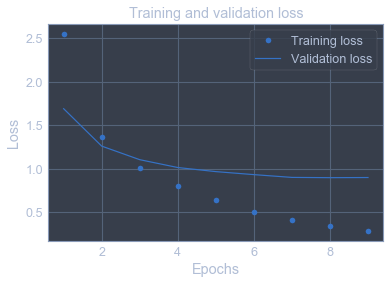

In [10]:
loss = cost.history['loss']
val_loss = cost.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

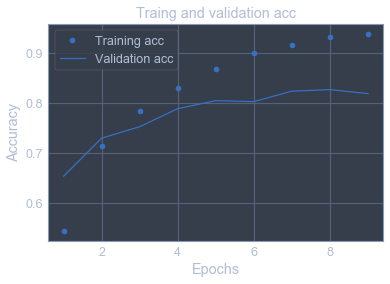

In [11]:
acc = cost.history['accuracy']
val_acc = cost.history['val_accuracy']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Traing and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 回归

## 预测房价：回归问题

In [12]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data,
                              test_targts) = boston_housing.load_data()

In [13]:
from sklearn.preprocessing import scale
train_data = scale(train_data)
test_data = scale(test_data)

In [14]:
def build_model():
    # 搭建网络
    model = Sequential()
    model.add(Dense(64, activation='relu',
                    input_shape=(train_data.shape[1], )))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    # 编译模型
    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
    return model

In [15]:
k = 4
num_epochs = 500
num_val_samples = len(train_data) // k
all_scores = []

for i in range(k):
    print('processing field NO.', i + 1)
    val_data = train_data[i * num_val_samples:(i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples:(i + 1) * num_val_samples]

    partical_train_data = np.concatenate([
        train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]
    ],
                                         axis=0)
    partical_train_targets = np.concatenate([
        train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]
    ],
                                            axis=0)
    model = build_model()
    print(u"开始训练————")
    print('训练中————')
    cost = model.fit(partical_train_data,
                     partical_train_targets,
                     validation_data=(val_data, val_targets),
                     epochs=num_epochs,
                     batch_size=1,
                     verbose=0)
    print("本轮训练完毕")
    mae_history = cost.history['val_mae']
    all_scores.append(mae_history)

processing field NO. 1
开始训练————
训练中————
本轮训练完毕
processing field NO. 2
开始训练————
训练中————
本轮训练完毕
processing field NO. 3
开始训练————
训练中————
本轮训练完毕
processing field NO. 4
开始训练————
训练中————
本轮训练完毕


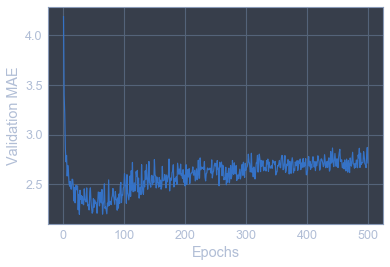

In [16]:
average_score = [
    np.mean([score[i] for score in all_scores]) for i in range(num_epochs)
]

plt.plot(range(1, len(average_score) + 1), average_score)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [17]:
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targts)
print(test_mse_score)
print(test_mae_score)

102/102 [==============================] - 0s 252us/step
16.752366159476487
2.725032091140747


# 循环神经网络与文本处理

## 一个简单的神经网络

In [18]:
max_features = 10000
maxlen = 500
batch_size = 32

print('正在下载数据......')
(input_train, y_train), (input_test,
                         y_test) = imdb.load_data(num_words=max_features)
print('下载完成')
print(len(input_train), 'train squences')
print(len(input_test), 'test squences')
print('正在加载数据......')

X_train = sequence.pad_sequences(input_train,
                                 maxlen=maxlen)  # 截取前500个单词，转换二维张量
X_test = sequence.pad_sequences(input_test, maxlen=maxlen)  # 截取前500个单词
print('完成数据预处理')
print('训练集形状：', X_train.shape)
print('测试机集形状：', X_test.shape)

正在下载数据......
下载完成
25000 train squences
25000 test squences
正在加载数据......
完成数据预处理
训练集形状： (25000, 500)
测试机集形状： (25000, 500)


In [ ]:
# 搭建网络
model = Sequential()
model.add(Embedding(max_features, 32))  # 整数索引映射为密集向量 ，如果其后接全连接层，需要用Flatten()展平
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

# 模型编译
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
cost = model.fit(X_train,
                 y_train,
                 epochs=10,
                 batch_size=128,
                 validation_split=0.2)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 21s 1ms/step - loss: 0.5892 - acc: 0.6788 - val_loss: 0.4531 - val_acc: 0.7956
Epoch 2/10
20000/20000 [==============================] - 22s 1ms/step - loss: 0.3900 - acc: 0.8383 - val_loss: 0.3542 - val_acc: 0.8548
Epoch 3/10
20000/20000 [==============================] - 20s 986us/step - loss: 0.2998 - acc: 0.8819 - val_loss: 0.3485 - val_acc: 0.8538
Epoch 4/10
20000/20000 [==============================] - 21s 1ms/step - loss: 0.2431 - acc: 0.9075 - val_loss: 0.3550 - val_acc: 0.8612
Epoch 5/10
20000/20000 [==============================] - 23s 1ms/step - loss: 0.1882 - acc: 0.9301 - val_loss: 0.5107 - val_acc: 0.8280
Epoch 6/10
20000/20000 [==============================] - 26s 1ms/step - loss: 0.1395 - acc: 0.9507 - val_loss: 0.3756 - val_acc: 0.8546
Epoch 7/10
20000/20000 [==============================] - 38s 2ms/step - loss: 0.0992 - acc: 0.9667 - val_loss: 0.4312 - val_ac

## LSTM神经网络

In [ ]:
# 搭建网络
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

# 模型编译
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
cost = model.fit(X_train,
                 y_train,
                 epochs=6,
                 batch_size=128,
                 validation_split=0.2)

加强理解embedding和validation_split

## 双向RNN

In [ ]:
# 构建网络
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation="sigmoid"))

# 编译模型
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
cost = model.fit(X_train,
                 y_train,
                 epochs=5,
                 batch_size=128,
                 validation_split=0.2)

# 卷积神经网络与信号处理

## 卷积神经网络的实现

In [ ]:
# 数据的准备
original_cat_dir = 'E:/Jupyter/Lib/DataSettings/PetImages/Cat/'
original_dog_dir = 'E:/Jupyter/Lib/DataSettings/PetImages/Dog/'

train_cat_dir = 'E:/Jupyter/Lib/DataSettings/PetImages/Exercise/train/Train_cat/'
validation_cat_dir = 'E:/Jupyter/Lib/DataSettings/PetImages/Exercise/validation/Validation_cat/'
test_cat_dir = 'E:/Jupyter/Lib/DataSettings/PetImages/Exercise//test/Test_cat/'

train_dog_dir = 'E:/Jupyter/Lib/DataSettings/PetImages/Exercise/train/Train_dog/'
validation_dog_dir = 'E:/Jupyter/Lib/DataSettings/PetImages/Exercise/validation/Validation_dog/'
test_dog_dir = 'E:/Jupyter/Lib/DataSettings/PetImages/Exercise/test/Test_dog/'

train_dir = 'E:/Jupyter/Lib/DataSettings/PetImages/Exercise/train/'
validation_dir = "E:/Jupyter/Lib/DataSettings/PetImages/Exercise/validation/"
test_dir = "E:/Jupyter/Lib/DataSettings/PetImages/Exercise/test/"
'''
os.mkdir(train_cat_dir)
os.mkdir(train_dog_dir)
os.mkdir(validation_cat_dir)
os.mkdir(validation_dog_dir)
os.mkdir(test_cat_dir)
os.mkdir(test_dog_dir)

for i in range(1000):
    cat_img = os.path.join(original_cat_dir,'%d.jpg'%i)
    cat_train = os.path.join(train_cat_dir,'%d.jpg'%i)
    dog_img = os.path.join(original_dog_dir,'%d.jpg'%i)
    dog_train = os.path.join(train_dog_dir,'%d.jpg'%i)
    shutil.copyfile(cat_img,cat_train)
    shutil.copyfile(dog_img,dog_train)
    
for i in range(1000,1500):
    cat_img = os.path.join(original_cat_dir,'%d.jpg'%i)
    cat_valid = os.path.join(validation_cat_dir,'%d.jpg'%i)
    dog_img = os.path.join(original_dog_dir,'%d.jpg'%i)
    dog_valid = os.path.join(validation_dog_dir,'%d.jpg'%i)
    shutil.copyfile(cat_img,cat_valid)
    shutil.copyfile(dog_img,dog_valid)
    
for i in range(1500,2000):
    cat_img = os.path.join(original_cat_dir,'%d.jpg'%i)
    cat_test = os.path.join(test_cat_dir,'%d.jpg'%i)
    dog_img = os.path.join(original_dog_dir,'%d.jpg'%i)
    dog_test = os.path.join(test_dog_dir,'%d.jpg'%i)
    shutil.copyfile(cat_img,cat_test)
    shutil.copyfile(dog_img,dog_test)    
'''

In [ ]:
keep_prob = 0.5
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dropout(rate=1 - keep_prob))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# 编译模型
rmsprop = RMSprop(lr=1e-4)
model.compile(loss="binary_crossentropy", optimizer=rmsprop, metrics=["acc"])

In [ ]:
# 数据预处理
train_data_gen = ImageDataGenerator(rescale=1. / 255)
test_data_gen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_data_gen.flow_from_directory(train_dir,
                                                     target_size=(150, 150),
                                                     batch_size=20,
                                                     class_mode='binary')

validation_generator = test_data_gen.flow_from_directory(validation_dir,
                                                         target_size=(150,
                                                                      150),
                                                         batch_size=20,
                                                         class_mode='binary')

# 训练模型
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=10,
                              validation_data=validation_generator,
                              validation_steps=50)

In [ ]:
from dl_tools import plot_loss
from dl_tools import plot_acc

plot_loss(history)

plt.figure()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(acc, 'bo', color="blue", label="Training acc")
plt.plot(val_acc, 'bo', color="red", label='Validation acc')
plt.title('Training & validation acc')
plt.legend()
plt.show()

## 使用预训练的卷积神经网络   

In [ ]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.trainable = False

In [ ]:
#  数据预训练
train_data_gen = ImageDataGenerator(rescale=1. / 255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')
test_data_gen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_data_gen.flow_from_directory(train_dir,
                                                     target_size=(150, 150),
                                                     batch_size=20,
                                                     class_mode='binary')

validation_generator = test_data_gen.flow_from_directory(validation_dir,
                                                         target_size=(150,
                                                                      150),
                                                         batch_size=20,
                                                         class_mode='binary')

In [ ]:
# 搭建网络
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation="sigmoid"))

# 编译模型
rmsprop = RMSprop(lr=1e-4)
model.compile(loss="binary_crossentropy",
              optimizer=rmsprop,
              metrics=["accuracy"])

# 训练模型
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=4,
                              validation_data=validation_generator,
                              validation_steps=50)

In [ ]:
plt.figure()
plt.plot(history.history['acc'], 'bo', color='blue', label='Training acc')
plt.plot(history.history['val_acc'], 'bo', color='red', label='Validation acc')
plt.legend()
plt.title('Training & validation acc')
plt.show()

plt.figure()
plt.plot(history.history['loss'], 'bo', color='blue', label='Training loss')
plt.plot(history.history['val_loss'],
         'bo',
         color='red',
         label='Validation loss')
plt.legend()
plt.title('Training & validation loss')
plt.show()

## 微调卷积神经网络模型

In [ ]:
# 冻结所有层并解冻某一层
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=6,
                              validation_data=validation_generator,
                              validation_steps=50)

In [ ]:
plt.figure()
plt.plot(history.history['acc'], 'bo', color='blue', label='Training acc')
plt.plot(history.history['val_acc'], 'bo', color='red', label='Validation acc')
plt.legend()
plt.title('Training & validation acc')
plt.show()

plt.figure()
plt.plot(history.history['loss'], 'bo', color='blue', label='Training loss')
plt.plot(history.history['val_loss'],
         'bo',
         color='red',
         label='Validation loss')
plt.legend()
plt.title('Training & validation loss')
plt.show()

## 卷积神经网络的可视化

In [ ]:
model = load_model('E:/Jupyter/Results/Model/cat_vs_dog_2.h5')

In [ ]:
img_path = 'E:/Jupyter/Lib/DataSettings/PetImages/Exercise/test/Test_cat/1637.jpg'
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)

plt.imshow(img_tensor[0])
plt.show()

In [ ]:
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
activations = activation_model.predict(img_tensor)

for i in range(8):
    layer_img = activations[i]
    for j in range(50):
        try:
            plt.matshow(layer_img[0, :, :, j], cmap='viridis')
            plt.show()
        except:
            continue

# 结合CNN与RNN处理长序列

一维卷积神经网络与一维池化

In [ ]:
max_features = 10000
maxlen = 500
batch_size = 128

print('正在下载数据......')
(input_train, y_train), (input_test,
                         y_test) = imdb.load_data(num_words=max_features)
print('下载完成')
print(len(input_train), 'train squences')
print(len(input_test), 'test squences')
print('正在加载数据......')

X_train = sequence.pad_sequences(input_train,
                                 maxlen=maxlen)  # 截取前500个单词，转换二维张量
X_test = sequence.pad_sequences(input_test, maxlen=maxlen)  # 截取前500个单词
print('完成数据预处理')
print('训练集形状：', X_train.shape)
print('测试机集形状：', X_test.shape)

In [ ]:
model = Sequential()
model.add(Embedding(max_features, batch_size, input_length=maxlen))
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
cost = model.fit(X_train,
                 y_train,
                 epochs=10,
                 batch_size=128,
                 validation_split=0.2)

# Keras函数式API：Model——多输入，多输出模型

In [ ]:
vocabulary_size = 10000
num_income_groups = 5

inputs = Input(shape=(None, ), name='posts')
embedding = Embedding(vocabulary_size, 128)(inputs)
x = LSTM(32, activation='relu')(embedding)
age_layer = Dense(1, name='age')(x)
income_layer = Dense(num_income_groups, activation='softmax', name='income')(x)
gender_layer = Dense(1, activation='sigmoid', name='gender')(x)

model = Model(inputs, [age_layer, income_layer, gender_layer])
model.compile(optimizer='rmsprop',
              loss={
                  'age': 'mse',
                  'income': 'categorical_crossentropy',
                  'gender': 'binary_crossentropy'
              },
              loss_weight={
                  "age": 0.25,
                  'income': 1.,
                  'gender': 10.
              })

# 回调函数

In [ ]:
max_features = 3000
maxlen = 500
batch_size = 128

print('正在下载数据......')
(input_train, y_train), (input_test,
                         y_test) = imdb.load_data(num_words=max_features)
print('下载完成')
print(len(input_train), 'train squences')
print(len(input_test), 'test squences')
print('正在加载数据......')

X_train = sequence.pad_sequences(input_train,
                                 maxlen=maxlen)  # 截取前500个单词，转换二维张量
X_test = sequence.pad_sequences(input_test, maxlen=maxlen)  # 截取前500个单词
print('完成数据预处理')
print('训练集形状：', X_train.shape)
print('测试机集形状：', X_test.shape)

model = Sequential()
model.add(Embedding(max_features, 32, input_length=maxlen,
                    name='embed'))  # 整数索引映射为密集向量 ，如果其后接全连接层，需要用Flatten()展平
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='sigmoid'))

# 模型编译
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
callback_list = [
    EarlyStopping(monitor='acc', patience=5),
    ModelCheckpoint(filepath='E:/Jupyter/Results/CallBack/call_back_1.h5',
                    monitor='val_loss',
                    save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3),
    TensorBoard(log_dir='E:/Jupyter/Results/TensorBoard/',
                histogram_freq=1,
                embeddings_freq=1,
                embeddings_data=X_train[:100].astype("float32"))
]

model.fit(X_train,
          y_train,
          epochs=20,
          validation_data=(X_test, y_test),
          callbacks=callback_list)

# 模型作图

tensorboard

In [ ]:
max_features = 800
maxlen = 500
batch_size = 128

print('正在下载数据......')
(input_train, y_train), (input_test,
                         y_test) = imdb.load_data(num_words=max_features)
print('下载完成')
print(len(input_train), 'train squences')
print(len(input_test), 'test squences')
print('正在加载数据......')

X_train = sequence.pad_sequences(input_train,
                                 maxlen=maxlen)  # 截取前500个单词，转换二维张量
X_test = sequence.pad_sequences(input_test, maxlen=maxlen)  # 截取前500个单词
print('完成数据预处理')
print('训练集形状：', X_train.shape)
print('测试机集形状：', X_test.shape)

model = Sequential()
model.add(
    Embedding(max_features, batch_size, input_length=maxlen,
              name='embed'))  # 整数索引映射为密集向量 ，如果其后接全连接层，需要用Flatten()展平
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1))

# 模型编译
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

# 回调函数
callback_list = [
    EarlyStopping(monitor='acc', patience=5),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3),
    TensorBoard(log_dir='E:/Jupyter/Results/TensorBoard/',
                histogram_freq=1,
                write_grads=True,
                embeddings_freq=1,
                embeddings_data=X_train[:100].astype("float32"))
]

# 训练模型
model.fit(X_train,
          y_train,
          epochs=20,
          validation_data=(X_test, y_test),
          callbacks=callback_list)

Plot Model

In [ ]:
from keras.utils import plot_model
import graphviz

In [ ]:
max_features = 800
maxlen = 500
batch_size = 128

model = Sequential()
model.add(
    Embedding(max_features, batch_size, input_length=maxlen,
              name='embed'))  # 整数索引映射为密集向量 ，如果其后接全连接层，需要用Flatten()展平
model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1))

# 模型编译
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

# 绘制模型流程图
plot_model(model,
           to_file='E:/Jupyter/Results/CallBack/model.png',
           show_shapes=True)

# 使用LSTM生成文本

In [ ]:
from keras import *

In [ ]:
path = 'E:/Jupyter/Lib/DataSettings/Peoms/yeats.txt'
text = open(path).read().lower()
print('Length:', len(text))

In [ ]:
maxlen = 60  # 每60个字符一序列
step = 3  # 每三个字符采样一新序列
sentences = []  # 保存所提取序列
next_chars = []  # 保存目标字符
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i:i + maxlen])
    next_chars.append(text[i + maxlen])
print('number of sentence:', len(sentences))
chars = sorted(list(set(text)))
print('Unique characters:', len(chars))
chars_indices = dict((char, chars.index(char)) for char in chars)

# one-hot编码
print('Vectorization......')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, chars_indices[char]] = 1
    y[i, chars_indices[next_chars[i]]] = 1

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))
optimizer = RMSprop(lr=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy')

In [ ]:
# 函数：给定模型预测，采样下一个字符
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


for epoch in range(1, 40):  # 模型训练60轮
    print('epoch:', epoch)
    model.fit(x, y, batch_size=128, epochs=1)  # 模型拟合一次

    start_index = random.randint(0, len(text) - maxlen - 1)  #
    generated_text = text[start_index:start_index + maxlen]  # 随机选取种子文本
    print('Generating with seeds:"' + generated_text + '"')  #

    for temperature in [0.2, 0.5, 1.0, 1.2]:  # 尝试一系列不同温度
        print('temperature:', temperature)
        sys.stdout.write(generated_text)

        for i in range(400):
            sampled = np.zeros((1, maxlen, len(chars)))  #
            for t, char in enumerate(generated_text):  # 对生成的字符进行one-hot编码
                sampled[0, t, chars_indices[char]] = 1.  #

            preds = model.predict(sampled, verbose=0)[0]  #
            next_index = sample(preds, temperature)  # 对下个字符采样
            next_char = chars[next_index]  #

            generated_text += next_char
            generated_text = generated_text[1:]
            sys.stdout.write(next_char)